In [ ]:
# # uncomment this cell for first run to install the packages.
# !pip install quandl
# !pip install ta 
# !pip install pycaret
# !pip install kats
# !pip install git+https://github.com/ourownstory/neural_prophet.git

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"
# %cd /content/gdrive/My Drive/Colab Notebooks

In [3]:
import numpy as np
import pandas as pd
import re
from math import sqrt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
# for mean_squared_error set squared = False for RMSE, (y_true, y_pred)
import random
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pycaret.regression import *
# import plotly.express as px

In [5]:
from kats.consts import TimeSeriesData

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
quandl.ApiConfig.api_key = "2At3atzXCrMx_BXfkyz7"
# 6b7jcHuxwW7Wot1kyFNS

### Data to be used

In [8]:
metadata = pd.read_csv('BSE_metadata.csv')
metadata.head()

,code,name,description,refreshed_at,from_date,to_date
0,BOM500002,ABB India Limited EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
1,BOM500003,AEGIS LOGISTICS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
2,BOM500008,AMARA RAJA BATTERIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
3,BOM500009,AMBALAL SARABHAI ENTERPRISES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
4,BOM500010,HOUSING DEVELOPMENT FINANCE CORP.LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,1/3/1992,1/18/2021


In [9]:
# metadata[metadata['name'].str.contains('sensex', case = False)]

## Utility variables and functions

In [10]:
### Codes of selected stocks
healthcare = ['BOM524715','BOM532488','BOM500124']
banking = ['BOM500180','BOM532174','BOM500247']
metals = ['BOM500470','BOM500228','BOM500440']
auto = ['BOM532977','BOM500570','BOM532500']
it = ['BOM500209','BOM532540','BOM507685']
BSE_HEALTHCARE = 'SI0800'
BSE_Information_Technology = 'SI1000'
BSE_BANKEX = 'SIBANK'
BSE_METAL = 'SI1200'
BSE_AUTO = 'SI1900'
SENSEX = 'SENSEX'

stocks = healthcare+banking+metals + auto+it
indices = [BSE_HEALTHCARE, BSE_Information_Technology, BSE_BANKEX, BSE_METAL, BSE_AUTO, SENSEX]
allSymbols = stocks + indices
ScriptWiseData = {}

In [11]:
# Global Variables
RSIColumn = 'RSI'
ATRColumns = ['TR', 'ATR']
MACDColumns = ['FastAverage', 'SlowAverage','MACD','Signal']
BollBandColumns = ['BB_up',"BB_dn","MA","BB_width"]
ADXColumns = ['pos_directional_indicator', 'neg_directional_indicator', 'adx']
OnBalanceVolume = 'OBV'
TechnicalIndicators = ['RSI', 'ATR', 'MACD', 'adx', 'OBV'] #exogenous variables

AllIndicatorColumns = [RSIColumn]+ATRColumns+MACDColumns+BollBandColumns+ADXColumns+[OnBalanceVolume]

In [12]:
# get null values of all the stocks
def getNullValuesForSetOfStocks(stockCodeList = allSymbols):
    nullCounts = pd.DataFrame(ScriptWiseData[stockCodeList[0]].isnull().sum(), columns= [getStockNameFromStockCode(stockCodeList[0])])
    for symbol in stockCodeList[1:]:
        currNull = pd.DataFrame(ScriptWiseData[symbol].isnull().sum(), columns= [getStockNameFromStockCode(symbol)])
        nullCounts = nullCounts.merge(currNull, left_index=True, right_index = True, how='outer')
    return nullCounts

In [13]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title
    """
    result = sts.adfuller(series.dropna(), autolag = 'AIC')
    label = ['ADF test statistic', 'p-value', '# lags used', '#observations']
    print(result)
    out = pd.Series(result[0:4], index=label)
    
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
    print(out.to_string())
    if(result[1]<0.05):
        return ('Data is stationary')
    else:
        return 'Data is non-stationary'

In [14]:
stockMetadata = metadata[metadata['code'].isin(allSymbols)]
stockMetadata.head()

,code,name,description,refreshed_at,from_date,to_date
70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021
121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021


In [15]:
print(stockMetadata.shape)
print(stockMetadata[stockMetadata['code'].isin(stocks)].shape)
print(stockMetadata[stockMetadata['code'].isin(indices)].shape)

(21, 6)
(15, 6)
(6, 6)


## Map Index to  stocks

In [16]:
stockMetadata.loc[:, 'isStock'] = 0
stockMetadata.loc[:, 'Index'] = ''

stockMetadata.loc[stockMetadata['code'].isin(stocks), 'isStock'] = 1
stockMetadata.reset_index(inplace=True)

In [17]:
stockMetadata.loc[stockMetadata['code'].isin(healthcare), 'Index'] = BSE_HEALTHCARE
stockMetadata.loc[stockMetadata['code'].isin(banking), 'Index'] = BSE_BANKEX
stockMetadata.loc[stockMetadata['code'].isin(metals), 'Index'] = BSE_METAL
stockMetadata.loc[stockMetadata['code'].isin(auto), 'Index'] = BSE_AUTO
stockMetadata.loc[stockMetadata['code'].isin(it), 'Index'] = BSE_Information_Technology

In [18]:
stockMetadata.head()

,index,code,name,description,refreshed_at,from_date,to_date,isStock,Index
0,70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021,1,SI0800
1,104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021,1,SIBANK
2,121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1000
3,133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1200
4,146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SIBANK


In [19]:
stockMetadata['isStock'].value_counts()

1    15
0     6
Name: isStock, dtype: int64

## Code to download the data from quandl. 

In [20]:
# # download the required data - needed only 1 time
# i=0
# code = f'BSE/{stockMetadata.loc[i, "code"]}'
# dataset = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
# dataset['StockName']=stockMetadata.loc[i, 'name']
# dataset['code'] = stockMetadata.loc[i, "code"]
# dataset['isStock'] = stockMetadata.loc[i, "isStock"]
# dataset['Index'] = stockMetadata.loc[i, "Index"]
# for i in range(1, len(stockMetadata)):
#     code = f'BSE/{stockMetadata.loc[i, "code"]}'
#     temp = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
#     temp['StockName']=stockMetadata.loc[i, 'name']
#     temp['code'] = stockMetadata.loc[i, "code"]
#     temp['isStock'] = stockMetadata.loc[i, "isStock"]
#     temp['Index'] = stockMetadata.loc[i, "Index"]
# #     print( stockMetadata.loc[i, "Index"])
#     dataset = dataset.append(temp)
# dataset.to_csv('data.csv')
# dataset.head()

In [21]:
dataset = pd.read_csv('data.csv')
dataset.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
0,2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
1,2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2,2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
3,2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
4,2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105449 entries, 0 to 105448
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       105449 non-null  object 
 1   Open                       95130 non-null   float64
 2   High                       95130 non-null   float64
 3   Low                        95130 non-null   float64
 4   Close                      105449 non-null  float64
 5   WAP                        74255 non-null   float64
 6   No. of Shares              74255 non-null   float64
 7   No. of Trades              74255 non-null   float64
 8   Total Turnover             74255 non-null   float64
 9   Deliverable Quantity       68110 non-null   float64
 10  % Deli. Qty to Traded Qty  68110 non-null   float64
 11  Spread H-L                 74255 non-null   float64
 12  Spread C-O                 74255 non-null   float64
 13  StockName                  10

### Verify the min and max of dates of all selected stocks and indices

In [23]:
dateRanges = dataset.groupby(['code', 'StockName']).agg({'Date': ['min', 'max']}).reset_index()
dateRanges

code                                      StockName        Date  \
                                                                     min   
0   BOM500124        DR.REDDY'S LABORATORIES LTD. EOD Prices  2000-01-03   
1   BOM500180                       HDFC Bank Ltd EOD Prices  2000-01-03   
2   BOM500209                        INFOSYS LTD. EOD Prices  2000-01-03   
3   BOM500228                      JSW STEEL LTD. EOD Prices  2000-01-03   
4   BOM500247            KOTAK MAHINDRA BANK LTD. EOD Prices  2000-01-03   
5   BOM500440            HINDALCO INDUSTRIES LTD. EOD Prices  2000-01-03   
6   BOM500470                     TATA STEEL LTD. EOD Prices  2000-01-03   
7   BOM500570                    TATA MOTORS LTD. EOD Prices  2000-01-03   
8   BOM507685                          WIPRO LTD. EOD Prices  2000-01-03   
9   BOM524715  SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices  2000-01-03   
10  BOM532174                     ICICI BANK LTD. EOD Prices  2000-01-03   
11  BOM532488            DIVI'S LABORATORIES LTD. EOD Prices  2003-03-12   
12  BOM532500            MARUTI SUZUKI INDIA LTD. EOD Prices  2003-07-09   
13  BOM532540      TATA CONSULTANCY SERVICES LTD. EOD Prices  2004-08-25   
14  BOM532977                     BAJAJ AUTO LTD. EOD Prices  2008-05-26   
15     SENSEX                                     BSE SENSEX  2000-01-03   
16     SI0800                                 BSE Healthcare  2000-01-03   
17     SI1000                     BSE Information Technology  2000-01-03   
18     SI1200                                      BSE METAL  2000-01-03   
19     SI1900                                       BSE AUTO  2000-01-03   
20     SIBANK                                     BSE BANKEX  2002-01-01   

                
           max  
0   2021-03-23  
1   2021-03-23  
2   2021-03-23  
3   2021-03-23  
4   2021-03-23  
5   2021-03-23  
6   2021-03-23  
7   2021-03-23  
8   2021-03-23  
9   2021-03-23  
10  2021-03-23  
11  2021-03-23  
12  2021-03-23  
13  2021-03-23  
14  2021-03-23  
15  2021-03-23  
16  2021-03-23  
17  2021-03-23  
18  2021-03-23  
19  2021-03-23  
20  2021-03-23

In [24]:
# use above ranges to get stockName
def getStockNameFromStockCode(stockCode):
    return dateRanges.loc[dateRanges.code==stockCode, 'StockName'].values[0];

In [25]:
data = dataset.set_index('Date')
data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
Date,,,,,,,,,,,,,,,,
2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


### Populate dictionary to hold individual Stock Data

In [26]:
for symbol in allSymbols:
    ScriptWiseData[symbol] = data.loc[data.code==symbol]
    
#     ScriptWiseData = {'Symbol1': <DatqaFrame>, 'Suymbol 2':Dataframe2}

### View null values in the data 

In [27]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,DIVI'S LABORATORIES LTD. EOD Prices,DR.REDDY'S LABORATORIES LTD. EOD Prices,HDFC Bank Ltd EOD Prices,ICICI BANK LTD. EOD Prices,KOTAK MAHINDRA BANK LTD. EOD Prices,TATA STEEL LTD. EOD Prices,JSW STEEL LTD. EOD Prices,HINDALCO INDUSTRIES LTD. EOD Prices,BAJAJ AUTO LTD. EOD Prices,TATA MOTORS LTD. EOD Prices,MARUTI SUZUKI INDIA LTD. EOD Prices,INFOSYS LTD. EOD Prices,TATA CONSULTANCY SERVICES LTD. EOD Prices,WIPRO LTD. EOD Prices,BSE Healthcare,BSE Information Technology,BSE BANKEX,BSE METAL,BSE AUTO,BSE SENSEX
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282


### Function to plot a set of stocks

In [28]:
colors = ['g','r','c','m','y','k']

In [29]:
def plotSet(groupName, columnName = 'Close'):
    color = random.shuffle(colors)
    i = 0
    c = len(groupName)
    for s in groupName:
        color = colors[i%len(colors)]
        i= i+1
        plt.subplot(c,1, i)
        label = getStockNameFromStockCode(s)
        s_data = data.loc[data.code==s , [columnName]]
        s_data[columnName].plot(figsize=(20, 10), color = color, label=label, legend = True)
        

In [30]:
def PlotMultipleColumns(scriptNames, columnNames):
    mixedColors =  sorted(colors, key=lambda k: random.random())
    numberOfScript = len(scriptNames)
    numberOfColumns = 2
    numberOfRows = numberOfScript//numberOfColumns + numberOfScript%numberOfColumns
    plotCount = 1
    
    for script in scriptNames:
        plt.subplot(numberOfRows,numberOfColumns, plotCount)
        title = getStockNameFromStockCode(script)
        s_data = ScriptWiseData[script]
        for color, col in enumerate(columnNames):
#             color = color%len(colors)
    #         s_data[col].plot(figsize=(30, 50), color = mixedColors[color], label=col, legend = True, title=title)
            s_data[col].plot(figsize=(30, 50), label=col, legend = True, title=title)
        plotCount = plotCount + 1


In [31]:
# s = 'SIBANK'
# color = random.shuffle(colors)
# label = getStockNameFromStockCode(s)
# s_data = data.loc[data.code==s , ['Close']]
# s_data.tail()

## Index Plots

In [32]:
# for index in indices:
#     index_data = data.loc[data.code==index , [ 'Close']]
#     label = dateRanges.loc[dateRanges.code==index, 'StockName'].values[0]
#     index_data.Close.plot(figsize=(20, 5), label=label, legend = True)
# plt.show()

In [33]:
# plotSet(indices)

In [34]:
# health care stocks
# plotSet(healthcare)

In [35]:
# banking stocks
# plotSet(banking)

In [36]:
# metals stocks
# plotSet(metals)

In [37]:
# auto stocks
# plotSet(auto)

In [38]:
# it stocks
# plotSet(it)

## Deriving Technical indicators 

### MACD

In [39]:
# function to create data MACD signal and data. 
def MACD(df, span1 = 12, span2= 26, span3 = 9):
    stockData = df.copy()
    stockData['FastAverage'] = stockData['Close'].ewm(span = span1, min_periods = span1).mean()
    stockData['SlowAverage'] = stockData['Close'].ewm(span = span2, min_periods = span2).mean()
    stockData['MACD'] = stockData['FastAverage'] - stockData['SlowAverage']
    stockData['Signal'] = stockData['MACD'].ewm(span=span3, min_periods = span3).mean()
    return stockData[MACDColumns]

In [40]:
MACD(ScriptWiseData[allSymbols[0]])

,FastAverage,SlowAverage,MACD,Signal
Date,,,,
2000-01-03,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-03-17,607.359088,608.847617,-1.488529,1.408562
2021-03-18,602.303844,606.303349,-3.999505,0.326948
2021-03-19,598.657099,604.251249,-5.594151,-0.857271


In [41]:
# create stock code based dataframes with MACD signal
for symbol in allSymbols:
    macd = MACD(ScriptWiseData[symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(macd, left_index=True, right_index = True, how='left')

In [42]:
adf_test(ScriptWiseData[stocks[0]]['Close'])

(-4.743054363455088, 6.98019700311808e-05, 24, 5256, {'1%': -3.431594767229596, '5%': -2.862090058410377, '10%': -2.567062795745212}, 53331.94641002593)
ADF test statistic        -4.743054
p-value                    0.000070
# lags used               24.000000
#observations           5256.000000
critical value (1%)       -3.431595
critical value (5%)       -2.862090
critical value (10%)      -2.567063


'Data is stationary'

### RSI - Relative Strength Index

In [43]:
# Calculating RSI without using loop
def RSI(DF, n=14):
    df =  DF.copy()
    "function to calculate RSI"
    delta = df['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    rsi = 100 - 100 / (1+rs);
    return pd.DataFrame(rs).rename(columns={'Close':'RSI'})

In [44]:
#RSI 
for symbol in allSymbols:   
    rsi = RSI(data.loc[data.code==symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(rsi, left_index=True, right_index = True, how='left')

## ATR

In [45]:
def ATR(DF,n=20):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2[ATRColumns]

In [46]:
#ATR 
for symbol in allSymbols:
    ScriptWiseData[symbol][ATRColumns] = ATR(data.loc[data.code==symbol])

## Bollinger band

In [47]:
def BollBnd(DF,n=14):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Close'].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
#     df.dropna(inplace=True)
    return df[BollBandColumns]

In [48]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][BollBandColumns] = BollBnd(data.loc[data.code==symbol])

## OBV

In [49]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['No. of Shares'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [50]:
#OBV
for symbol in allSymbols:
    ScriptWiseData[symbol]['OBV'] = OBV(data.loc[data.code==symbol])

<AxesSubplot:title={'center':'Bollinger Band'}, xlabel='Date'>

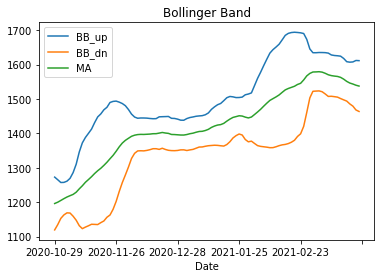

In [51]:
# # Visualizing Bollinger Band of the stocks for last 100 data points
BollBnd(ScriptWiseData['BOM500180'],20).iloc[-100:,[-4,-3,-2]].plot(title="Bollinger Band")

In [52]:
from ta.trend import ADXIndicator
def ADX(DF):
    df = DF.copy()
    adxI = ADXIndicator(df['High'],df['Low'],df['Close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()
    return df[ADXColumns]

In [53]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][ADXColumns] = ADX(data.loc[data.code==symbol])

In [54]:
# view sample data
ScriptWiseData['BOM500180'].head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index,FastAverage,SlowAverage,MACD,Signal,RSI,TR,ATR,BB_up,BB_dn,MA,BB_width,OBV,pos_directional_indicator,neg_directional_indicator,adx
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,165.0,174.4,165.00,174.4,173.133670,112119.0,518.0,19411574.0,NaN,NaN,9.40,9.4,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2000-01-04,179.5,187.0,170.25,174.0,175.702585,330118.0,1394.0,58002586.0,NaN,NaN,16.75,-5.5,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,NaN,NaN,NaN,NaN,NaN,16.75,NaN,NaN,NaN,NaN,NaN,-330118.0,0.0,0.0,0.0
2000-01-05,165.5,173.0,162.00,168.5,168.061387,149249.0,815.0,25082994.0,NaN,NaN,11.00,3.0,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,NaN,NaN,NaN,NaN,NaN,12.00,NaN,NaN,NaN,NaN,NaN,-479367.0,0.0,0.0,0.0
2000-01-06,169.9,170.8,166.00,167.5,168.079908,70268.0,494.0,11810639.0,NaN,NaN,4.80,-2.4,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,NaN,NaN,NaN,NaN,NaN,4.80,NaN,NaN,NaN,NaN,NaN,-549635.0,0.0,0.0,0.0
2000-01-07,165.0,169.9,162.50,169.5,166.105160,183026.0,970.0,30401563.0,NaN,NaN,7.40,4.5,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,NaN,NaN,NaN,NaN,NaN,7.40,NaN,NaN,NaN,NaN,NaN,-366609.0,0.0,0.0,0.0


### Get Null Values for all columns

In [55]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,DIVI'S LABORATORIES LTD. EOD Prices,DR.REDDY'S LABORATORIES LTD. EOD Prices,HDFC Bank Ltd EOD Prices,ICICI BANK LTD. EOD Prices,KOTAK MAHINDRA BANK LTD. EOD Prices,TATA STEEL LTD. EOD Prices,JSW STEEL LTD. EOD Prices,HINDALCO INDUSTRIES LTD. EOD Prices,BAJAJ AUTO LTD. EOD Prices,TATA MOTORS LTD. EOD Prices,MARUTI SUZUKI INDIA LTD. EOD Prices,INFOSYS LTD. EOD Prices,TATA CONSULTANCY SERVICES LTD. EOD Prices,WIPRO LTD. EOD Prices,BSE Healthcare,BSE Information Technology,BSE BANKEX,BSE METAL,BSE AUTO,BSE SENSEX
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282


## Dropping null values

In [56]:
# drop rows from the stock whose technical indicator values are null. 
for stock in stocks:
    ScriptWiseData[stock] = ScriptWiseData[stock].dropna(subset=AllIndicatorColumns)

In [57]:
# ScriptWiseData['BOM500180'][ScriptWiseData['BOM500180']['MACD'].isna()]
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,DIVI'S LABORATORIES LTD. EOD Prices,DR.REDDY'S LABORATORIES LTD. EOD Prices,HDFC Bank Ltd EOD Prices,ICICI BANK LTD. EOD Prices,KOTAK MAHINDRA BANK LTD. EOD Prices,TATA STEEL LTD. EOD Prices,JSW STEEL LTD. EOD Prices,HINDALCO INDUSTRIES LTD. EOD Prices,BAJAJ AUTO LTD. EOD Prices,TATA MOTORS LTD. EOD Prices,MARUTI SUZUKI INDIA LTD. EOD Prices,INFOSYS LTD. EOD Prices,TATA CONSULTANCY SERVICES LTD. EOD Prices,WIPRO LTD. EOD Prices,BSE Healthcare,BSE Information Technology,BSE BANKEX,BSE METAL,BSE AUTO,BSE SENSEX
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Deliverable Quantity,515,24,505,505,511,504,512,547,522,1,509,48,506,2,505,5282,5282,4784,5282,5282,5282
% Deli. Qty to Traded Qty,515,24,505,505,511,504,512,547,522,1,509,48,506,2,505,5282,5282,4784,5282,5282,5282


## Train test and validation split

In [58]:
# def TrainTestSplit(dataset, exog, test_start = None, test_end = None, ratio = None):
#     if(test_start)

## Scaling of data

In [59]:
# view sample data
ScriptWiseData['BOM500180'].head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index,FastAverage,SlowAverage,MACD,Signal,RSI,TR,ATR,BB_up,BB_dn,MA,BB_width,OBV,pos_directional_indicator,neg_directional_indicator,adx
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-02-18,251.0,251.0,240.50,246.00,245.838244,182132.0,1236.0,44775011.0,NaN,NaN,10.50,-5.00,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,239.293097,228.265820,11.027277,11.854728,1.667609,10.50,14.6975,258.900577,223.527994,241.214286,35.372582,4261113.0,35.769381,24.529829,34.706836
2000-02-21,250.0,252.0,236.65,239.50,243.037920,117669.0,872.0,28598029.0,NaN,NaN,15.35,-10.50,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,239.325020,229.158347,10.166673,11.476506,1.363886,15.35,14.4000,258.898369,223.523060,241.210714,35.375308,4143444.0,32.818085,24.575341,33.253621
2000-02-22,237.0,240.0,220.50,222.00,226.922722,166659.0,1162.0,37818714.0,NaN,NaN,19.50,-15.00,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,236.653101,228.592674,8.060427,10.729087,0.894131,19.50,14.6850,260.029492,219.534794,239.782143,40.494699,3976785.0,29.489362,30.483122,30.996721
2000-02-23,224.0,230.0,217.10,222.45,224.391434,109551.0,679.0,24582306.0,NaN,NaN,12.90,-1.55,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,234.463480,228.109653,6.353827,9.789465,0.903620,12.90,14.3550,260.482377,218.639052,239.560714,41.843325,4086336.0,27.502036,30.205029,29.117240
2000-02-24,220.0,229.0,218.00,228.00,223.142662,85075.0,576.0,18983862.0,NaN,NaN,11.00,8.00,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,233.467355,228.101070,5.366285,8.853366,1.029013,11.00,14.0375,260.649912,218.114374,239.382143,42.535539,4171411.0,25.899240,28.444705,27.372008


In [60]:
num_columns = list(ScriptWiseData[allSymbols[0]].select_dtypes(include='float64').columns)

In [61]:
#Scale all numerical columns using standard scaler
for symbol in allSymbols:
    scaler = StandardScaler() # min max scaler, first value scaling
    ScriptWiseData[symbol][num_columns] = scaler.fit_transform(ScriptWiseData[symbol][num_columns])

In [62]:
# view sample data
ScriptWiseData['BOM500180'].head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index,FastAverage,SlowAverage,MACD,Signal,RSI,TR,ATR,BB_up,BB_dn,MA,BB_width,OBV,pos_directional_indicator,neg_directional_indicator,adx
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-02-18,-1.196037,-1.203842,-1.203056,-1.203205,-1.203276,-0.023605,-0.470234,-0.308211,NaN,NaN,-0.643412,-0.215407,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,-1.217100,-1.237938,0.229515,0.265430,0.561442,-0.421428,-0.598288,-1.199044,-1.198138,-1.212359,-0.329203,-2.502380,1.915040,0.520728,0.945163
2000-02-21,-1.197611,-1.202281,-1.209176,-1.213440,-1.207686,-0.150047,-0.538217,-0.342911,NaN,NaN,-0.431488,-0.502580,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,-1.217049,-1.236519,0.208206,0.255476,0.107392,-0.298465,-0.612668,-1.199048,-1.198146,-1.212365,-0.329190,-2.508913,1.488848,0.526079,0.809869
2000-02-22,-1.218069,-1.221005,-1.234848,-1.240995,-1.233065,-0.053955,-0.484055,-0.323132,NaN,NaN,-0.250150,-0.737540,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,-1.221275,-1.237418,0.156056,0.235805,-0.594870,-0.193250,-0.598892,-1.197353,-1.204652,-1.214622,-0.303572,-2.518167,1.008152,1.220643,0.599752
2000-02-23,-1.238526,-1.236607,-1.240252,-1.240286,-1.237051,-0.165970,-0.574263,-0.351525,NaN,NaN,-0.538542,-0.035271,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,-1.224739,-1.238186,0.113801,0.211076,-0.580684,-0.360580,-0.614843,-1.196674,-1.206113,-1.214972,-0.296823,-2.512084,0.721166,1.187948,0.424772
2000-02-24,-1.244821,-1.238168,-1.238822,-1.231547,-1.239018,-0.213979,-0.593501,-0.363533,NaN,NaN,-0.621564,0.463367,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,-1.226314,-1.238200,0.089350,0.186440,-0.393226,-0.408751,-0.630189,-1.196423,-1.206969,-1.215254,-0.293359,-2.507361,0.489708,0.980991,0.262291


## Exploratory Data Analysis

In [63]:
# PlotMultipleColumns(stocks, ['Close', 'MACD'])

### Regression Models

## ARIMAX

In [64]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [65]:
# help(auto_arima)

## Stats models basic ARIMA

In [66]:
dataSet = ScriptWiseData['BOM500180']
ARIMAXModel = ARIMA(dataSet.Close, exog = dataSet[TechnicalIndicators], order= (1, 1, 1))
ARIMAXModel = ARIMAXModel.fit()
ARIMAXModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 5248
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7541.891
Method:                       css-mle   S.D. of innovations              0.057
Date:                Sat, 10 Jul 2021   AIC                         -15065.781
Time:                        15:20:05   BIC                         -15006.691
Sample:                             1   HQIC                        -15045.122
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.477      0.633      -0.001       0.002
RSI               0.0133      0.001     13.039      0.000       0.011       0.015
ATR              -0.0049      0.001     -5.354      0.000      -0.007      -0.003
MACD             -0.0053      0.001     -5.139      0.000      -0.007      -0.003
adx              -0.0051      0.001     -5.565      0.000      -0.007      -0.003
OBV               0.0018      0.001      2.014      0.044    4.89e-05       0.004
ar.L1.D.Close    -0.0817      1.099     -0.074      0.941      -2.235       2.071
ma.L1.D.Close     0.0742      1.099      0.067      0.946      -2.081       2.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -12.2444           +0.0000j           12.2444            0.5000
MA.1          -13.4783           +0.0000j           13.4783            0.5000
-----------------------------------------------------------------------------
"""

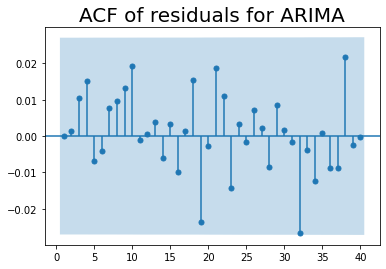

In [67]:
residual = ARIMAXModel.resid
sgt.plot_acf(residual[1:], zero=False, lags = 40)
plt.title("ACF of residuals for ARIMA", size =20)
plt.show()

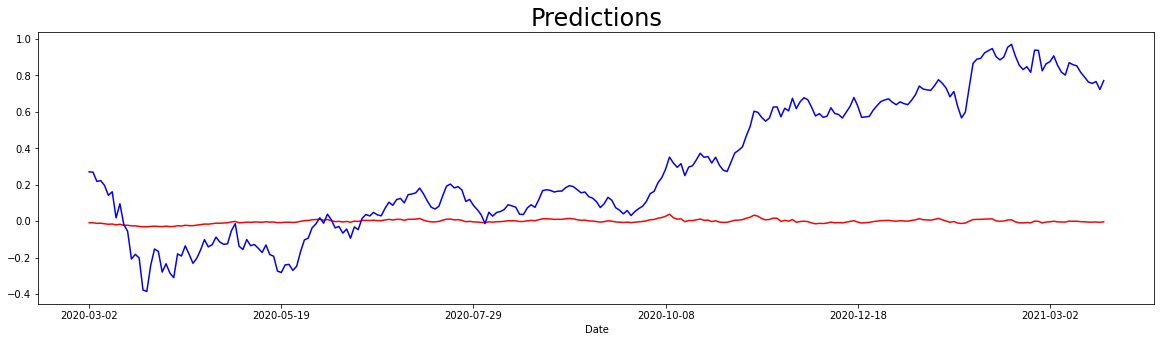

In [68]:
# prediction start and end dates. Should be business days.
start_date = '2020-03-02'
end_date = '2021-03-23'
df_pred = ARIMAXModel.predict(start = start_date, end = end_date)
df_pred[start_date:end_date].plot(figsize= (20, 5), color='red')
dataSet[start_date:end_date]['Close'].plot(color='blue')
plt.title("Predictions", size=24)
plt.show()

In [69]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, ]
d_values = range(0, 1)
q_values = range(0, 1)
# dataSet = ScriptWiseData['BOM500180']
# evaluate_models(dataSet.Close, p_values, d_values, q_values)

In [70]:
# start_date = '2020-03-02'
# end_date = '2021-03-23'
# def HyperParameterTuningARIMAX(dataset, exog = None , p_values = None, d_values = None, q_values = None):
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     train, test = TrainTestSplit(dataset, exog, test_start = start_date, test_end = end_date)
#                     predictions = list()
#                     ARIMAXModel = ARIMA(dataSet.Close, exog = dataSet[exog], order= order)
#                     ARIMAXModel = ARIMAXModel.fit()
#                     df_pred = ARIMAXModel.predict(start = start_date, end = end_date)
#                     predictions.append(df_pred)
#                     rmse = sqrt(mean_squared_error(test, predictions))
#                     return rmse
#                 except:
#                     return

## kats library modelling

In [71]:
dataSet = ScriptWiseData['BOM500180'].reset_index()
dataSet.head(2)

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index,FastAverage,SlowAverage,MACD,Signal,RSI,TR,ATR,BB_up,BB_dn,MA,BB_width,OBV,pos_directional_indicator,neg_directional_indicator,adx
0,2000-02-18,-1.196037,-1.203842,-1.203056,-1.203205,-1.203276,-0.023605,-0.470234,-0.308211,NaN,NaN,-0.643412,-0.215407,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,-1.217100,-1.237938,0.229515,0.265430,0.561442,-0.421428,-0.598288,-1.199044,-1.198138,-1.212359,-0.329203,-2.502380,1.915040,0.520728,0.945163
1,2000-02-21,-1.197611,-1.202281,-1.209176,-1.213440,-1.207686,-0.150047,-0.538217,-0.342911,NaN,NaN,-0.431488,-0.502580,HDFC Bank Ltd EOD Prices,BOM500180,1,SIBANK,-1.217049,-1.236519,0.208206,0.255476,0.107392,-0.298465,-0.612668,-1.199048,-1.198146,-1.212365,-0.329190,-2.508913,1.488848,0.526079,0.809869


In [72]:
dataSetClosing = dataSet[['Date', 'Close']]
dataSetClosing.columns = ['time', 'value']
dataSetClosing = TimeSeriesData(dataSetClosing)
dataSetClosing #.head(2)

,time,value
0,2000-02-18,-1.203205
1,2000-02-21,-1.213440
2,2000-02-22,-1.240995
3,2000-02-23,-1.240286
4,2000-02-24,-1.231547
...,...,...
5244,2021-03-17,0.764428
5245,2021-03-18,0.756082
5246,2021-03-19,0.766711
5247,2021-03-22,0.722938


In [73]:
dataSetMulti = dataSet[['Date', 'Close']+ MACDColumns]
dataSetMulti.columns = ['time', 'v1', 'v2', 'v3', 'v4', 'v5']
dataSetMulti = TimeSeriesData(dataSetMulti,time=dataSetMulti.time, value=dataSetMulti[['v1', 'v2']])
dataSetMulti#.head(2)

,time,v1,v2,v3,v4,v5
0,2000-02-18,-1.203205,-1.217100,-1.237938,0.229515,0.265430
1,2000-02-21,-1.213440,-1.217049,-1.236519,0.208206,0.255476
2,2000-02-22,-1.240995,-1.221275,-1.237418,0.156056,0.235805
3,2000-02-23,-1.240286,-1.224739,-1.238186,0.113801,0.211076
4,2000-02-24,-1.231547,-1.226314,-1.238200,0.089350,0.186440
...,...,...,...,...,...,...
5244,2021-03-17,0.764428,0.836183,0.847920,-0.117516,0.136782
5245,2021-03-18,0.756082,0.824707,0.842015,-0.205185,0.065745
5246,2021-03-19,0.766711,0.816639,0.837343,-0.258697,-0.002460
5247,2021-03-22,0.722938,0.803048,0.829743,-0.353079,-0.077088


## SARIMA MODEL

In [74]:
from kats.models.sarima import SARIMAModel, SARIMAParams
warnings.simplefilter(action='ignore')

# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=dataSetClosing, params=params)

# fit SARIMA model
# m.fit()

# generate forecast values
# fcst = m.predict(    steps=5,     freq="D"    )

# make plot to visualize
# m.plot()

### VARMAX MODEL

In [164]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

In [165]:
def DifferenceToMakeStationary(data, n):
    data_transformed = data
    for i in range(n):
        data_transformed = data_transformed.diff()
    data_transformed = data_transformed.dropna()
    return data_transformed

In [166]:
def InvertDifferencingForActualResults(data,data_differenced, forecast, column, order):
    df_forecast = forecast.copy()
    n = len(forecast)
    for i in range(order):
        tempColumn = f'{column}{i}'
        # Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
        df_forecast[tempColumn] = (data[column].iloc[-n-1]-data[column].iloc[-n-2]) + df_forecast[column].cumsum()
        # Now build the forecast values from the first difference set
        df_forecast['Forecast'] = df[column].iloc[-n-1] + df_forecast[tempColumn].cumsum()

In [167]:
def getAutoArimaParams(stockSymbol, data):
#     cache auto arima results
    pass

In [168]:
# Train and fit varmax model
def VARMAXProcedure(stockSymbol):
    
    data = ScriptWiseData[stockSymbol][['Close']+TechnicalIndicators] #.reset_index();
    data.index.freq = 'B'
    # determine values of p,d, q by auto arima.
    params = auto_arima(data['Close'], maxiter = 1000)
    p, d, q = params.order
    # make data stationary based on auto arima output
    data_transformed = DifferenceToMakeStationary(data, d)
    # train test spllit
    train, test = TrainTestSplitByDateRange(data_transformed)
    # fit the model based on above parameters
    model = VARMAX(train, order=(p,q))
    results = model.fit(maxiter=1000, disp=False)
    forecasts = results.forecast(len(test))
    #     forecasts = InvertDifferencingForActualResults()
    return results, forecasts

0 1 1


In [75]:
model, forecasts = VARMAXProcedure(stocks[0])

NameError: name 'train' is not defined

## Prophet models

In [ ]:
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(dataSetClosing, params)

# fit model simply by calling m.fit()
# m.fit()

# make prediction for next 10 days
# fcst = m.predict(steps=10, freq="B")

# plot to visualize
# m.plot()

### Hyper Parameter tuning

In [ ]:
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from kats.models.arima import ARIMAParams, ARIMAModel

from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator

In [ ]:
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
}
]

In [ ]:
parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

In [ ]:
# Divide into an 80/20 training-test split
split = int(0.8*len(dataSetClosing))

train_ts = dataSetClosing[0:split]
test_ts = dataSetClosing[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    arima_params = ARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = ARIMAModel(train_ts, arima_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error

In [ ]:
# parameter_tuner_grid.generate_evaluate_new_parameter_values(
#     evaluation_function=evaluation_function
# )

# # Retrieve parameter tuning results

# parameter_tuning_results_grid = (parameter_tuner_grid.list_parameter_value_scores())
# parameter_tuning_results_grid

## Neural Prophet and AR-Net

In [ ]:
from neuralprophet import NeuralProphet, set_random_seed , set_log_level
set_random_seed(0)
set_log_level("ERROR")

In [ ]:
df = ScriptWiseData['BOM500180'].reset_index()
df = df[['Date', 'Close']]
df.columns = ['ds', 'y']
df.head()

### Basic Model

In [ ]:
def BuildNeuralProphetModels(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', 'Close']]
    df.columns = ['ds', 'y']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D')
    val_metrics = m.test(df_val)
    
    # make forecasts
    # future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
    future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

In [ ]:
# m = NeuralProphet()
# metrics = m.fit(df, freq="D")
m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData['BOM500180'])

#### Make predictions for a year ahead

In [ ]:
# future = m.make_future_dataframe(df, periods=365)
# forecast = m.predict(future)

#### Plot the forecast

In [ ]:
 forecasts_plot = m.plot(forecast)

In [ ]:
fig_comp = m.plot_components(forecast)

In [ ]:
fig_param = m.plot_parameters()

#### Validating the dataset

In [ ]:
m = NeuralProphet()
df_train, df_val = m.split_df(df, valid_p=0.2, freq='D')

In [ ]:
train_metrics = m.fit(df_train, freq='D')
val_metrics = m.test(df_val)

## Multiple regressors

In [ ]:
def BuildNeuralProphetModelsWithMultipleRegressors(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', 'Close']+TechnicalIndicators]
    df.columns = ['ds', 'y', 'A', 'B', 'C', 'D', 'E']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    # lagged regressors
    m.add_lagged_regressor(name='A')
    m.add_lagged_regressor(name='B')
    m.add_lagged_regressor(name='C')
    m.add_lagged_regressor(name='D')
    m.add_lagged_regressor(name='E')
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D')
    val_metrics = m.test(df_val)
    
    # make forecasts
    # future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
    future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

In [ ]:
m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData['BOM500180'])
forecasts_plot = m.plot(forecast)

In [ ]:
fig_comp = m.plot_components(forecast)

In [ ]:
train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [False, False]).head(3)

In [ ]:
train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [True, True]).head(3)

In [ ]:
val_metrics